# Introduction to PySpark

Some exploration into using PySpark for Data Science. 

Generally, pandas should only be used with 5 to 10 times as much RAM as the size of your dataset, whereas PySpark is scalable and allows for parallel programming.

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

## Spark SQL

In [3]:
df = spark.sql("select 'spark' as hello")
df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



## Reading Data

Using NYC flights in 2013:
- Converting to parquet format and reloading so that only data used is loaded to memory
- Query spark dataframe

In [4]:
file_location = "data/flight_data.csv"
df = spark.read.format("csv").option("inferSchema", True).option("header", True).load(file_location)
display(df)

DataFrame[year: int, month: int, day: int, dep_time: string, sched_dep_time: int, dep_delay: string, arr_time: string, sched_arr_time: int, arr_delay: string, carrier: string, flight: int, tailnum: string, origin: string, dest: string, air_time: string, distance: int, hour: int, minute: int, time_hour: string]

In [5]:
# df.write.save("data/flight_data_parquet", format='parquet')
df = spark.read.load("data/flight_data_parquet")
display(df)
# df.show()

DataFrame[year: int, month: int, day: int, dep_time: string, sched_dep_time: int, dep_delay: string, arr_time: string, sched_arr_time: int, arr_delay: string, carrier: string, flight: int, tailnum: string, origin: string, dest: string, air_time: string, distance: int, hour: int, minute: int, time_hour: string]

In [6]:
# Convert air time column type
from pyspark.sql.types import *
df = df.withColumn("air_time", df["air_time"].cast(IntegerType()))

In [7]:
df.createOrReplaceTempView("flights")
year_flights = spark.sql("""
    select year, month, sum(distance) as total_distance
    from flights
    group by 1, 2
    order by 1, 2
    """)
year_flights.show()

+----+-----+--------------+
|year|month|total_distance|
+----+-----+--------------+
|2013|    1|      27188805|
|2013|    2|      24975509|
|2013|    3|      29179636|
|2013|    4|      29427294|
|2013|    5|      29974128|
|2013|    6|      29856388|
|2013|    7|      31149199|
|2013|    8|      31149334|
|2013|    9|      28711426|
|2013|   10|      30012086|
|2013|   11|      28639718|
|2013|   12|      29954084|
+----+-----+--------------+



# Plotting

Either convert to a pandas dataframe or use Apache Zeppelin to plot.

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
year_flights_pd = year_flights.toPandas()

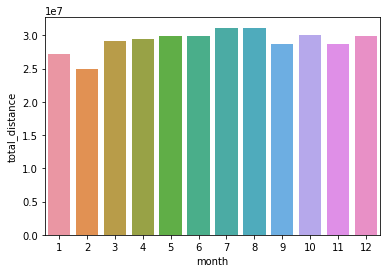

In [10]:
sns.barplot(x="month", y="total_distance", data=year_flights_pd)

## Model Fitting

While scikit-learn is great when working with pandas, it doesn’t scale to large data sets in a distributed environment. MLlib is most generally used and operates natively on spark dataframes (although it is possible to parallelize scikit-learn with spark). 

In [11]:
from pyspark.ml.feature import VectorAssembler  # Create a vector representation for features
from pyspark.ml.regression import LinearRegression

In [12]:
# Drop nulls
df = df.filter(df['air_time'].isNotNull())
df = df.filter(df['distance'].isNotNull())
# df.drop.na()

In [13]:
# Simple model for air time vs flight distance
assembler = VectorAssembler(inputCols=['air_time'], outputCol='features')
train_df = assembler.transform(df)
lr_model = LinearRegression(featuresCol = 'features', labelCol='distance').fit(train_df)
trainingSummary = lr_model.summary

In [14]:
print("Coefficients: " + str(lr_model.coefficients))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("R2: %f" % trainingSummary.r2)

Coefficients: [7.781414355687039]
RMSE: 100.400201
R2: 0.981387


A high R2 score means that the distance travelled is well explained by the flight air time, as would be expected.

## Scaling Pandas Operations

We can use pandas UDFs (user defined functions) to perform distributed computing with pandas dataframes within a spark environment. This is the preferred method of parallelization because it distributes threads across driver nodes. Note that we use the `groupby` and `apply` functions on a spark dataframe.

This avoids the need to convert the whole dataframe using toPandas(), which will fail for large dataframes due to an out of memory exception. We can thus scale to large datasets as long as we have a good way to partition the dataframe. 

This requires pyarrow. `pip install pyarrow`

In [15]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import col, count, rand, collect_list, explode, struct, lit

In [16]:
# Aggregate function is to sum
year_flights_pd.dropna(inplace=True)
total_distance = sum(year_flights_pd['total_distance'])
total_distance

350217607

In [17]:
group_column = 'year'
x_columns = ['total_distance']
schema = year_flights.select(group_column, *x_columns).schema  # define the output format

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def year_sum(pdf):
    group_key = pdf[group_column].iloc[0]
    x = pdf[x_columns]
    total_distance = x.sum()
    return pd.DataFrame({group_column: [group_key],
                         x_columns[0]: [total_distance]})

year_flights.groupby(group_column).apply(year_sum).show()

+----+--------------+
|year|total_distance|
+----+--------------+
|2013|     350217607|
+----+--------------+



In [18]:
@pandas_udf(year_flights.schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def pandas_subtract_mean(pdf):
    return pdf.assign(total_distance=pdf.total_distance - pdf.total_distance.mean())

year_flights.groupby('year').apply(pandas_subtract_mean).agg(count(col('total_distance'))).show()

+---------------------+
|count(total_distance)|
+---------------------+
|                   12|
+---------------------+



In [19]:
import statsmodels.api as sm

# df2 has four columns: id, y, x1, x2
df2 = year_flights.withColumn('y', rand()).withColumn('x1', rand()).withColumn('x2', rand()).select('year', 'y', 'x1', 'x2')

group_column = 'year'
y_column = 'y'
x_columns = ['x1', 'x2']
schema = df2.select(group_column, *x_columns).schema

@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def ols(pdf):
    group_key = pdf[group_column].iloc[0]
    y = pdf[y_column]
    X = pdf[x_columns]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return pd.DataFrame([[group_key] + [model.params[i] for i in x_columns]], columns=[group_column] + x_columns)

beta = df2.groupby(group_column).apply(ols)
beta.show()

+----+-------------------+-------------------+
|year|                 x1|                 x2|
+----+-------------------+-------------------+
|2013|0.07333048090834393|0.06719204507058933|
+----+-------------------+-------------------+



## Parallelization 

There are other ways to parallelize operations outside of pandas UDFs:
- If we use spark dataframes and libraries then the task will be natively parallelized and distributed
- The multiprocessing library provides a thread abstraction to create concurrent threads of execution, this doesn't however distribute across driver nodes unless using spark dataframes or libraries

In [20]:
from multiprocessing.pool import ThreadPool
pool = ThreadPool(2)  # 2 concurrent threads

In [21]:
parameters = [1, 2, 3]
base_val = 5
def add_val(a, b):
    return a + b

pool.map(lambda x: add_val(base_val, x), parameters)

[6, 7, 8]

In [22]:
base_df = pd.DataFrame({'a': [1, 2, 3, 4],
                        'b': [2, 2, 3, 3],
                        'c': [5, 4, 3, 2]
                       })

def return_val(df, key):
    return df[df['a'] == key]

return_df = pool.map(lambda x: return_val(base_df, x), parameters)  # list of pandas dataframes
return_df[0]

,a,b,c
0,1,2,5
